In [1]:
!pip install pyspark==3.0.1 py4j==0.10.9

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 MB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 15.6 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612223 sha256=43b42820dfc85482465e472fff341eddf2e806841ed3247f187daaa446584b19
  Stored in directory: /root/.cache/pip/wheels/19/b0/c8/6cb894117070e130fc44352c2a13f15b6c27e440d04a84fb48
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [77]:
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType
from pyspark.sql.functions import col, lit
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import desc
from pyspark.sql import functions as f
import matplotlib.pyplot as plt

In [78]:
spark = SparkSession.builder\
        .master("local[*]")\
        .appName('PySpark_Tutorial')\
        .getOrCreate()

In [79]:
data = spark.read.csv(
    'bestsellers_with_categories.csv',
    sep=',',
    header=True,
)

data.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- User Rating: string (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Genre: string (nullable = true)



In [80]:
data_schema = [
               StructField('Name', StringType(), True),
               StructField('Author', StringType(), True),
               StructField('User Rating', FloatType(), True),
               StructField('Reviews', IntegerType(), True),
               StructField('Price', IntegerType(), True),
               StructField('Year', IntegerType(), True),
               StructField('Genre', StringType(), True)
            ]

final_struc = StructType(fields = data_schema)

data = spark.read.csv(
    'bestsellers_with_categories.csv',
    sep=',',
    header=True,
    schema=final_struc
)

data.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- User Rating: float (nullable = true)
 |-- Reviews: integer (nullable = true)
 |-- Price: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Genre: string (nullable = true)



In [81]:
data.columns

['Name', 'Author', 'User Rating', 'Reviews', 'Price', 'Year', 'Genre']

In [82]:
data = data.withColumn('Year', data.Year)

data.show(5)

+--------------------+--------------------+-----------+-------+-----+----+-----------+
|                Name|              Author|User Rating|Reviews|Price|Year|      Genre|
+--------------------+--------------------+-----------+-------+-----+----+-----------+
|10-Day Green Smoo...|            JJ Smith|        4.7|  17350|    8|2016|Non Fiction|
|   11/22/63: A Novel|        Stephen King|        4.6|   2052|   22|2011|    Fiction|
|12 Rules for Life...|  Jordan B. Peterson|        4.7|  18979|   15|2018|Non Fiction|
|1984 (Signet Clas...|       George Orwell|        4.7|  21424|    6|2017|    Fiction|
|5,000 Awesome Fac...|National Geograph...|        4.8|   7665|   12|2019|Non Fiction|
+--------------------+--------------------+-----------+-------+-----+----+-----------+
only showing top 5 rows



In [83]:
data = data.na.drop()

numeric_columns = ['User Rating', 'Reviews', 'Price', 'Year']
for col in numeric_columns:
    mean_value = data.selectExpr(f'mean(`{col}`)').collect()[0][0]
    data = data.na.fill(mean_value, [col])

for col in numeric_columns:
    data = data.withColumn(col, data[col].cast(FloatType()))

In [84]:
data.select('Reviews').show(5)

data.select(['Reviews', 'Price', 'Year']).show(5)

+-------+
|Reviews|
+-------+
|17350.0|
| 2052.0|
|18979.0|
|21424.0|
| 7665.0|
+-------+
only showing top 5 rows

+-------+-----+------+
|Reviews|Price|  Year|
+-------+-----+------+
|17350.0|  8.0|2016.0|
| 2052.0| 22.0|2011.0|
|18979.0| 15.0|2018.0|
|21424.0|  6.0|2017.0|
| 7665.0| 12.0|2019.0|
+-------+-----+------+
only showing top 5 rows



In [85]:
data.dtypes

[('Name', 'string'),
 ('Author', 'string'),
 ('User Rating', 'float'),
 ('Reviews', 'float'),
 ('Price', 'float'),
 ('Year', 'float'),
 ('Genre', 'string')]

In [86]:
data.first()

Row(Name='10-Day Green Smoothie Cleanse', Author='JJ Smith', User Rating=4.699999809265137, Reviews=17350.0, Price=8.0, Year=2016.0, Genre='Non Fiction')

In [87]:
data.describe().show()

+-------+--------------------+----------------+-------------------+------------------+------------------+------------------+-----------+
|summary|                Name|          Author|        User Rating|           Reviews|             Price|              Year|      Genre|
+-------+--------------------+----------------+-------------------+------------------+------------------+------------------+-----------+
|  count|                 550|             550|                550|               550|               550|               550|        550|
|   mean|                null|            null| 4.6183636452934955|11953.281818181818|              13.1|            2014.0|       null|
| stddev|                null|            null|0.22698038875323445|11731.132017431892|10.842261978422364|3.1651563841692782|       null|
|    min|"The Plant Parado...|Abraham Verghese|                3.3|              37.0|               0.0|            2009.0|    Fiction|
|    max|You Are a Badass:...|    Zhi Gan

In [88]:
data.count()

550

In [89]:
new_columns = [col.lower().replace(' ', '_') for col in data.columns]
data = data.toDF(*new_columns)
data.head(5)

[Row(name='10-Day Green Smoothie Cleanse', author='JJ Smith', user_rating=4.699999809265137, reviews=17350.0, price=8.0, year=2016.0, genre='Non Fiction'),
 Row(name='11/22/63: A Novel', author='Stephen King', user_rating=4.599999904632568, reviews=2052.0, price=22.0, year=2011.0, genre='Fiction'),
 Row(name='12 Rules for Life: An Antidote to Chaos', author='Jordan B. Peterson', user_rating=4.699999809265137, reviews=18979.0, price=15.0, year=2018.0, genre='Non Fiction'),
 Row(name='1984 (Signet Classics)', author='George Orwell', user_rating=4.699999809265137, reviews=21424.0, price=6.0, year=2017.0, genre='Fiction'),
 Row(name='5,000 Awesome Facts (About Everything!) (National Geographic Kids)', author='National Geographic Kids', user_rating=4.800000190734863, reviews=7665.0, price=12.0, year=2019.0, genre='Non Fiction')]

In [90]:
highest_rating = data.orderBy(desc('user_rating')).select('author').first()[0]
print("Автор з найвищим рейтингом: ", highest_rating)

Автор з найвищим рейтингом:  Bill Martin Jr.


In [91]:
lowest_rating = data.orderBy('user_rating').select('author').first()[0]
print("Автор з найнижчим рейтингом: ", lowest_rating)

Автор з найнижчим рейтингом:  J.K. Rowling


In [92]:
most_reviews = data.orderBy(desc('reviews')).select('author').first()[0]
print("Автор з найбільшою к-стю рецензій: ", most_reviews)

Автор з найбільшою к-стю рецензій:  Delia Owens


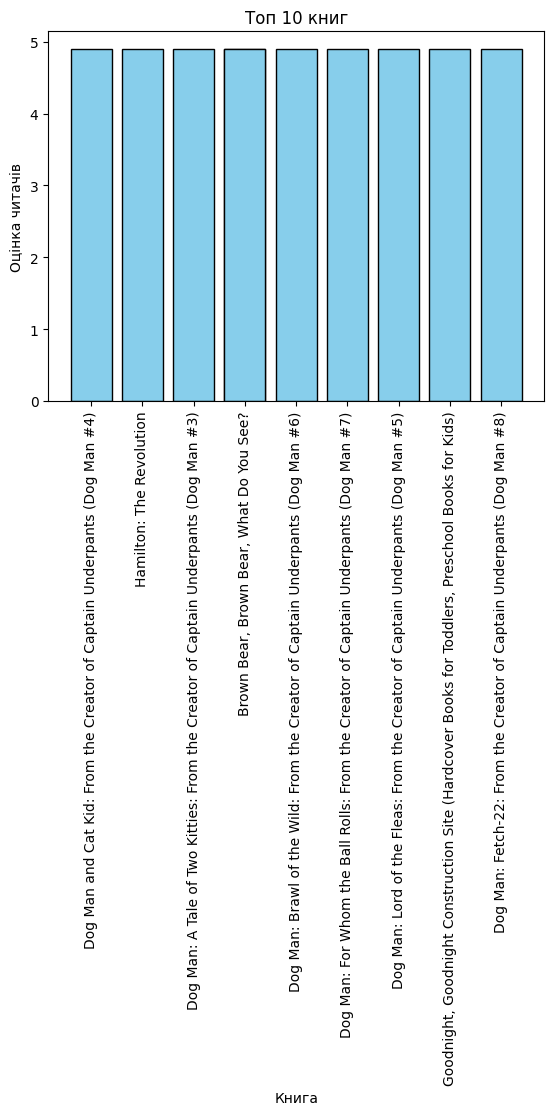

In [95]:
top_10_books = data.orderBy(desc('user_rating')).limit(10)

book_names = [row['name'] for row in top_10_books.collect()]
ratings = [row['user_rating'] for row in top_10_books.collect()]

plt.bar(book_names, ratings, color='skyblue', edgecolor='black')
plt.xlabel('Книга')
plt.ylabel('Оцінка читачів')
plt.title('Топ 10 книг')
plt.xticks(rotation=90)
plt.show()

In [98]:
assembler = VectorAssembler(inputCols=['user_rating', 'reviews', 'price'], outputCol='features')
data_assembled = assembler.transform(data).select('features')

correlation_matrix = Correlation.corr(data_assembled, 'features').head()
corr_matrix = correlation_matrix[0].toArray()

print("Матриця кореляції:")
print(corr_matrix)

Матриця кореляції:
[[ 1.         -0.00172901 -0.13308631]
 [-0.00172901  1.         -0.10918188]
 [-0.13308631 -0.10918188  1.        ]]
